In [21]:
import os
import sys
import torch
import numpy as np
import json

import matplotlib.pyplot as plt
from skimage.io import imread
from utils import *

# Util function for loading meshes
from pytorch3d.io import load_obj

# Data structures and functions for rendering
from pytorch3d.structures import Meshes
from pytorch3d.renderer import (
    look_at_view_transform,
    FoVPerspectiveCameras, 
    FoVOrthographicCameras, 
    Materials, 
    RasterizationSettings, 
    MeshRenderer, 
    MeshRasterizer,  
    SoftPhongShader,
    TexturesVertex,
    TexturesAtlas,
    PointsRenderer,
    PointsRasterizationSettings,
    PointsRasterizer
)

In [22]:
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    torch.cuda.set_device(device)
else:
    device = torch.device("cpu")

In [23]:
params = Params("param.json")
obj_filename = params.obj_filename

In [24]:
# Get vertices, faces, and auxiliary information:
verts, faces, aux = load_obj(
    obj_filename,
    device=device,
    load_textures=True,
    create_texture_atlas=True,
    texture_atlas_size=4,
    texture_wrap="repeat"
     )

# Create a textures object
atlas = aux.texture_atlas

# Initialize the mesh with vertices, faces, and textures.
# Created Meshes object
capsule_mesh = Meshes(
    verts=[verts],
    faces=[faces.verts_idx],
    textures=TexturesAtlas(atlas=[atlas]),)

In [25]:
print('We have {0} vertices and {1} faces.'.format(verts.shape[0], faces.verts_idx.shape[0]))

We have 3393 vertices and 5328 faces.


In [26]:
# Initialize the camera with camera distance, elevation, and azimuth angle
R, T = look_at_view_transform(dist = params.camera_dist, elev = 
                              params.elevation, azim = params.azim_angle) 
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

# Here we set the output image to be of size 256 x 256 based on config.json 
raster_settings = RasterizationSettings(
    image_size = params.image_size, 
    blur_radius = 0.0, 
    faces_per_pixel = 1, 
)

# Initialize rasterizer by using a MeshRasterizer class
rasterizer = MeshRasterizer(
        cameras=cameras, 
        raster_settings=raster_settings
    )

In [27]:
# The textured phong shader interpolates the texture uv coordinates for 
# each vertex, and samples from a texture image.
shader = SoftPhongShader(device = device, cameras = cameras)

# Create a mesh renderer by composing a rasterizer and a shader
renderer = MeshRenderer(rasterizer, shader)

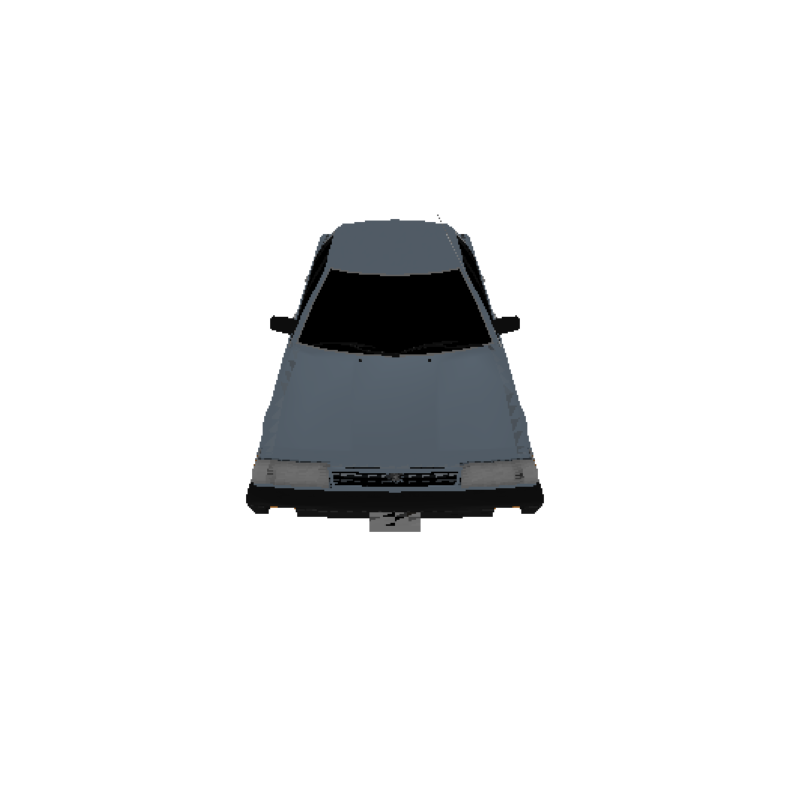

In [28]:
# Render Meshes object
image = renderer(capsule_mesh)
# Plot rendered image
plt.figure(figsize=(10, 10))
plt.imshow(image[0, ..., :3].cpu().numpy())
plt.grid("off");
plt.axis("off");

In [29]:
# The batch size represents the number of different viewpoints from which we 
# want to render the mesh.
batch_size = 12

# Create a batch of meshes by repeating the capsule mesh and associated textures. 
# Meshes has a useful `extend` method which allows us do this very easily. 
meshes = capsule_mesh.extend(batch_size)

# Get a batch of viewing angles. 
elev = torch.linspace(-360, 360, batch_size)
azim = torch.linspace(180, 360, batch_size)

# All the cameras helper methods support mixed type inputs and broadcasting. So we can 
# view the camera from the same distance and then specify elevation and azimuth angles 
# for each viewpoint as tensors. 
R, T = look_at_view_transform(dist = params.camera_dist, elev = params.elevation, azim = azim)
cameras = FoVPerspectiveCameras(device=device, R=R, T=T)

In [30]:
# We can pass arbirary keyword arguments to the rasterizer/shader via the renderer
# so the renderer does not need to be reinitialized if any of the settings change.
images = renderer(meshes, cameras=cameras)

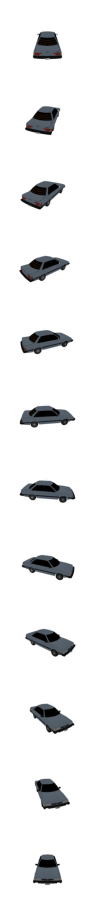

In [31]:
# Plot the rendered images
image_grid(images.cpu().numpy(), rgb=True)